In [1]:
#Libraries

import matplotlib.pyplot as plt
import os
from glob import glob

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


import cv2
from pathlib import Path
import random
import torch.nn as nn

- Obtaining images and captions

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/My\ Drive/data/data > /dev/null

- Functions for visualization

In [ ]:
#Given an image, return captions

def extract_captions(image_name, captions_text):
    captions = []
    for line in captions_text.splitlines():
        parts = line.split(',')
        if len(parts) == 2 and parts[0] == image_name:
            captions.append(parts[1])

    return captions

#Visualization of image and one of its captions

def visualize_images(folder_path, captions, num_images_per_row=3, max_caption_length=40):
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')] # All of them are .jpg ?

    random.shuffle(file_names) # Just because I want to see different images every time
    file_names = file_names[:12]  # Only 12 images


    num_images = len(file_names)
    num_rows = (num_images + num_images_per_row - 1) // num_images_per_row

    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(12, 9))

    for i, file_name in enumerate(file_names):
        img_path = os.path.join(folder_path, file_name)
        img = plt.imread(img_path)
        ax = axes[i // num_images_per_row, i % num_images_per_row]
        ax.imshow(img)
        ax.axis('off')

        caption = extract_captions(file_name, captions)

        # To avoid overlaping between captions from different images 

        if len(caption[0]) > max_caption_length:
            caption_lines = [caption[0][0:max_caption_length], caption[0][max_caption_length:]]
            ax.text(0.5, -0.3, caption_lines[0] + '\n' + caption_lines[1], transform=ax.transAxes, fontsize=10, ha='center')
        else:
            ax.text(0.5, -0.3, caption[0], transform=ax.transAxes, fontsize=10, ha='center')

    for j in range(len(file_names), num_rows * num_images_per_row):
        fig.delaxes(axes[j // num_images_per_row, j % num_images_per_row])

    plt.tight_layout()
    plt.show()



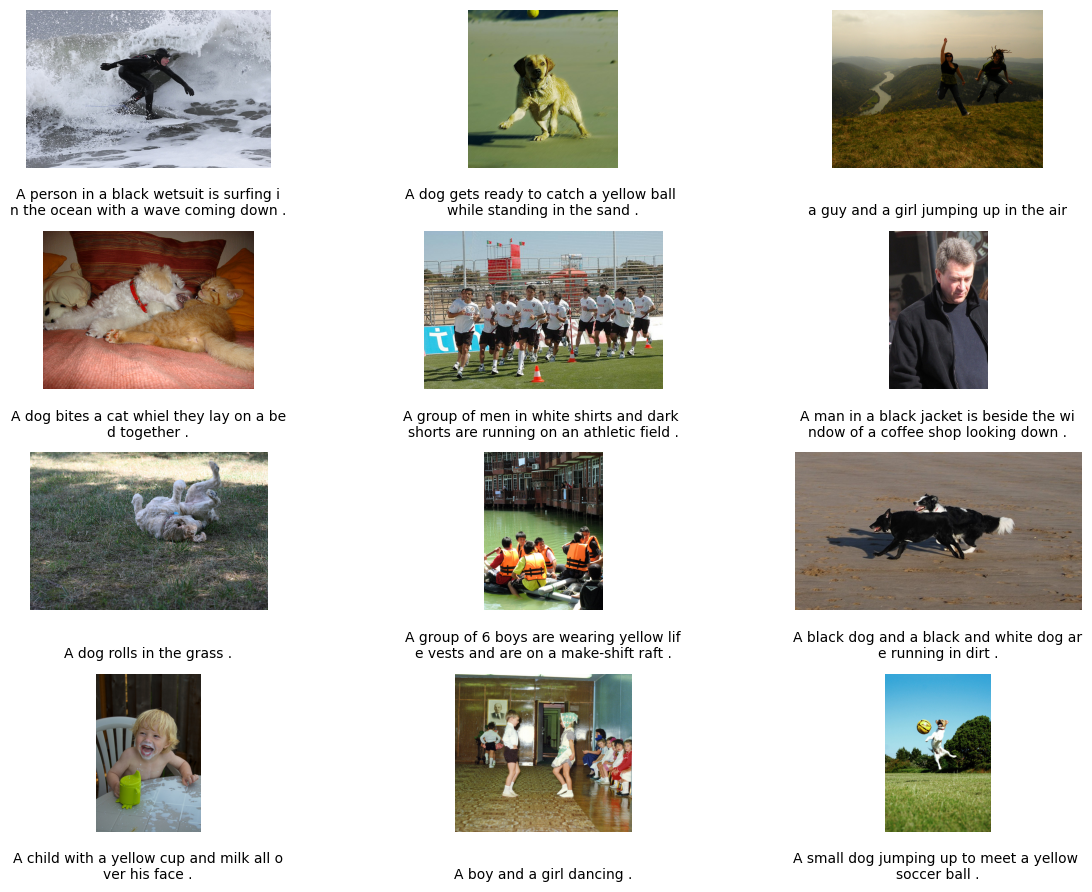

In [ ]:
with open("captions.txt", "r") as file:
    captions = file.read()

visualize_images(folder_path= "Images", captions=captions)

- Using ResNet18

In [2]:
# Load the ResNet50 model

"""
"pretrained=True" argument - > Pre-trained weights for ResNet-18. 
 By default - > Weights trained on the ImageNet dataset.

"""

model = models.resnet18(pretrained=True)
model.eval()



C:\Users\Júlia Garcia Torné\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Júlia Garcia Torné\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Júlia Garcia Torné/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
10

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- Dealing with images

In [3]:
imageFilesDir = Path(r'Images')
files = list(imageFilesDir.rglob('*.jpg'))

mean = np.array([0., 0., 0.])
std = np.array([0., 0., 0.])

numSamples = len(files)

for i in range(numSamples):
    im = cv2.imread(str(files[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) #To RGB
    im = im.astype(float) / 255. # Normalized pixels [0-1]
    
    for j in range(3):
        mean[j] += np.mean(im[:,:,j]) # j = 0 - > R, j = 1 - > G, j = 2 - > B
        std[j] += np.std(im[:,:,j])

mean = mean / numSamples
std = std / numSamples

print("Mean:", mean)
print("Standard Deviation:", std)


In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image: ResNet model  - > (224,224,3)
    transforms.ToTensor(), # Img to Python Tensor
    transforms.Normalize(mean=mean, std=std), # image = (image - mean) / std
])

In [ ]:
images_dir = "Images"

file_names = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
random_file = random.choice(file_names) # Pick one image at random

image_path = os.path.join(images_dir, random_file)
original_image = Image.open(image_path).convert('RGB')

normalized_image = preprocess(original_image)
normalized_image = torch.clamp(normalized_image, 0, 1)

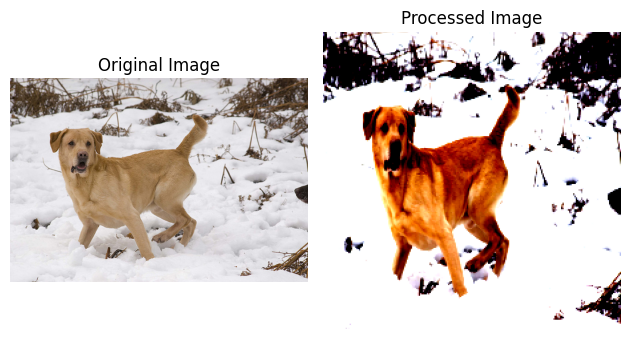

In [ ]:
fig, axs = plt.subplots(1, 2)

# Original Image
axs[0].imshow(original_image)
axs[0].set_title("Original Image")

# Preprocessed Image
axs[1].imshow(normalized_image.permute(1, 2, 0))
axs[1].set_title("Processed Image")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

- Extracting Features

In [ ]:
# Extracting features from images using ResNet50 😀

def extract_image_features(images_path):

    features = {} # Features dictionary - > IMAGE_NAME : FEATURES
    file_names = [f for f in os.listdir(images_path) if f.endswith('.jpg')]

    file_names = file_names[:200] #Just doing it for 500 images, delete it if you want

    for img_name in file_names:
        img_path = os.path.join(images_path, img_name)

        # print(img_path)

        img = Image.open(img_path).convert('RGB')
        img = preprocess(img)
        img = img.unsqueeze(0)

        feature = model(img)
        feature = torch.flatten(feature, start_dim=1)

        features[img_name] = feature

    return features

In [ ]:
images_path = "Images"
features = extract_image_features(images_path)

#shapes = [value.shape for value in features.values()]
#print(shapes)


- Activation maps of ResNet18

In [ ]:
images_path = "Images"
file_names = [f for f in os.listdir(images_path) if f.endswith('.jpg')]

random_index = random.randint(0, len(file_names) - 1)
img_name = file_names[random_index]

img_path = os.path.join(images_path, img_name)


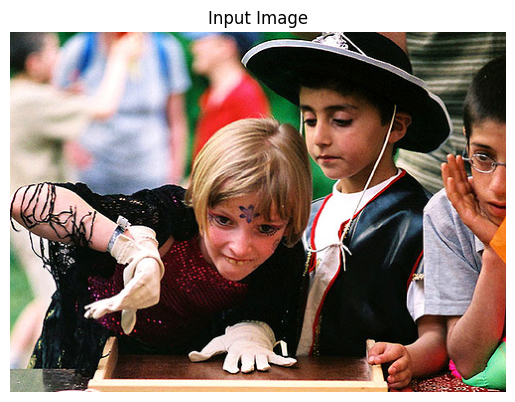

In [ ]:
input_image = Image.open(img_path).convert('RGB')

plt.imshow(input_image)
plt.axis('off')
plt.title("Input Image")

input_image = preprocess(input_image)
input_image = input_image.unsqueeze(0) 


In [100]:
num_layers = 0
conv_layers = []

In [48]:
model_children = list(model.children())

In [ ]:
model_children

In [101]:
for child in model_children:
  #print(child)

  if type(child) == nn.Conv2d:
    conv_layers.append(child)
    num_layers+=1    

  if type(child) == nn.Sequential: #Then, we look into the children of the child
    for layer in child.children():
      for layer in layer.children():
        if type(layer) == nn.Conv2d:
          #print(layer)
          conv_layers.append(layer)
          num_layers+=1      

In [103]:
num_layers

17

In [113]:
conv_layers

[Conv2d(128, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(256, 256, kernel_s

In [105]:
input_image.shape

torch.Size([1, 3, 224, 224])

In [108]:
results = [conv_layers[0](input_image)]

for i in range(1, len(conv_layers)):
  results.append(conv_layers[i](results[-1])) #Use the last element of the list as input to the following layer

In [109]:
len(results)

17

In [110]:
results[0].shape # Because first layer - > 64 filters. Then, ouput 64 channels

torch.Size([1, 64, 112, 112])

In [111]:
results[2].shape

torch.Size([1, 64, 112, 112])

Here, we create a file that contains multiple files, where each file corresponds to the resulting activation maps each layer:

In [ ]:
output_dir = "Feature maps"
os.makedirs(output_dir, exist_ok=True)

for num_layer in range(len(results)):
    layer_dir = os.path.join(output_dir, f"Layer {num_layer + 1}")
    os.makedirs(layer_dir, exist_ok=True)
    
    layer = results[num_layer].squeeze()
    #print("Layer", num_layer + 1)
    
    for i, f in enumerate(layer):
        plt.imshow(f.detach().numpy())
        plt.axis("off")
        
        # Save the image file in the layer directory
        file_name = f"image_{i + 1}.png"
        file_path = os.path.join(layer_dir, file_name)
        plt.savefig(file_path)
        plt.close()
    
print("Layer outputs saved successfully.")


The activation maps represent the presence of certain features or patterns in an input image.
- Darker regions in the activation maps indicate lower activation values or the absence of the corresponding features.
- Lighter regions indicate higher activation values or the presence of the features.